## Self supervised large scale generalisation - Affables negatives 

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

In [2]:
s3_prefixes = []

for m in ["0", "150", "300","450","600","750","900", "1050", "1200"]:
    for i in ["00", "01", "02", "03", "04"]:
        s3_prefixes.append(f"s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-affable-2000-500-{m}-bert-f1-{i}-202212092007/202212111930/")

In [3]:
label_order = ["False", "True"]
pos_labels = list( filter(lambda x: x , label_order))
label_order_key = lambda x:  label_order.index(x)

label_title_map = {}

In [4]:
local_temp = "../temp"
local_temp_pred_dir = os.path.join( local_temp, "pred_results")
local_temp_wk_dir = os.path.join( local_temp, "wk")

In [5]:
import shutil
import boto3
import glob
from multiprocessing.dummy import Pool as ThreadPool
import argparse
import datetime 
import os


def setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir):
    if os.path.exists(local_temp):
        shutil.rmtree(local_temp)
    os.makedirs(local_temp_pred_dir)
    os.makedirs(local_temp_wk_dir)

    


def upload_file(localpath, s3path):
        """
Uploads a file to s3
        :param localpath: The local path
        :param s3path: The s3 path in format s3://mybucket/mydir/mysample.txt
        """

        bucket, key = get_bucketname_key(s3path)

        if key.endswith("/"):
            key = "{}{}".format(key, os.path.basename(localpath))
        
        s3 = boto3.client('s3')
        
        s3.upload_file(localpath, bucket, key)

def get_bucketname_key(uripath):
    assert uripath.startswith("s3://")

    path_without_scheme = uripath[5:]
    bucket_end_index = path_without_scheme.find("/")

    bucket_name = path_without_scheme
    key = "/"
    if bucket_end_index > -1:
        bucket_name = path_without_scheme[0:bucket_end_index]
        key = path_without_scheme[bucket_end_index + 1:]

    return bucket_name, key


def download_file(s3path, local_dir):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')
    
    local_file = os.path.join(local_dir, s3path.split("/")[-1])
    

    s3.download_file(bucket, key, local_file)
    
def download_object(s3path):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')    

    s3_response_object = s3.get_object(Bucket=bucket, Key=key)
    object_content = s3_response_object['Body'].read()
    
    return len(object_content)



def list_files(s3path_prefix):
    assert s3path_prefix.startswith("s3://")
    assert s3path_prefix.endswith("/")
    
    bucket, key = get_bucketname_key(s3path_prefix)
    
   
   
    s3 = boto3.resource('s3')
    
    bucket = s3.Bucket(name=bucket)

    return ( (o.bucket_name, o.key) for o in bucket.objects.filter(Prefix=key))





def upload_files(local_dir, s3_prefix, num_threads=20):    
    input_tuples = ( (f,  s3_prefix) for f in glob.glob("{}/*".format(local_dir)))
    
    with ThreadPool(num_threads) as pool:
        pool.starmap(uploadfile, input_tuples)
    


def download_files(s3_prefix, local_dir, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        
        

def download_objects(s3_prefix, num_threads=20):    
    s3_files = ( "s3://{}/{}".format(s3_bucket,s3_key) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.map(download_object, s3_files)
        
    return sum(results)/1024
        

def get_directory_size(start_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

def get_s3file_size(bucket, key):
    s3 = boto3.client('s3')
    response = s3.head_object(Bucket=bucket, Key=key)
    size = response['ContentLength']
    return size
    
def download_files_min_files(s3_prefix, local_dir, min_file_size=310, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix) if get_s3file_size(s3_bucket, s3_key) > min_file_size )
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        

In [6]:
def load_df_from_files(local_temp_pred_dir):
   
    list_df = []
    for f in os.listdir(local_temp_pred_dir):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )
        df["prediction"]=df["prediction"].astype(str)
        list_df.append(df)
    return pd.concat(list_df)


In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



keywords1 = ["activation", "trigger", "interact", "inhibit", "regulat", "supress"]

keywords2 = ["gene", "protein", "chemical"]

def self_label(df):
   

    df["self_label"] = df["abstract"].apply(lambda x: any([ k.lower() in x.lower() for k in keywords1]) 
                                        and sum([  k.lower() in x.lower() for k in keywords2])>=2
                                     
                                       ).astype(str)
    
    
    return df

def plot_confusionmatrix(y_true,y_pred, normalize=None):
    cm = confusion_matrix(y_true,y_pred,labels=["False", "True"], normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels =  ["False", "True"])
    disp.plot(cmap="PuBu", xticks_rotation="vertical")

In [8]:


def get_summary_df(local_temp_pred_dir, use_std=False):
    list_df_high_quality = []
    list_df_low_quality = []
    list_df_summary = []
    for f in sorted(os.listdir(local_temp_pred_dir)):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )
        df["prediction"]=df["prediction"].astype(str)
        df=df.pipe(self_label)
        
        list_df_summary.append(df[["prediction", "confidence", "confidence_std", "abstract_id", "self_label"]])

 
    return  pd.concat(list_df_summary)




In [9]:
%%time 
from sklearn.metrics import precision_recall_fscore_support
import regex as re
import io, sagemaker

def create_stats_df(s3_prefix, confidence=0.0):
    print(f"Running {s3_prefix}, confidence {confidence}")

    setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir)
    download_files(s3_prefix, local_temp_pred_dir)
    df = get_summary_df (local_temp_pred_dir)


    total_predictions= len(df)
    df = df.query(f"confidence > {confidence} ")

    name = s3_prefix
    r = re.search(  "predictions_selfsup-affable-(\d+)-(\d+)-(\d+)", s3_prefix)
    name= s3_prefix
    train_size= int(r.group(1))
    train_pos_size= int(r.group(2))
    train_affable_neg=  int(r.group(3))
    prediction_above_threshold = len(df)

    p,r,f,s = precision_recall_fscore_support(df["self_label"], 
                         df["prediction"], pos_label = "True", average="binary", zero_division=0)
        
    return { "Name": name, 
                    "Precision":p,
                    "Recall":r,
                    "F1":f,  
                  #  "Threshold": "HighConfidence", 
                    "Support": s, 
                        "TrainSize":train_size, "TrainSizePositive": train_pos_size,
                        "TrainAffableNegative" : train_affable_neg,
                        "TrainAffableNegativeRate" : train_affable_neg/(train_size- train_pos_size),
                        "PredictionsSize": total_predictions, 
                   "PredictionsAboveThresholdSize": prediction_above_threshold,
                    "PredictionsAboveThresholdRatio" :prediction_above_threshold/total_predictions
           
           }
    
    

def create_stats_dfs_from_prefixes(s3_prefixes):
    result = [ create_stats_df(s, confidence=0.0) for s in s3_prefixes]
    df =  pd.DataFrame(result)
    return df

df_stats = create_stats_dfs_from_prefixes(s3_prefixes)

Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-affable-2000-500-0-bert-f1-00-202212092007/202212111930/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-affable-2000-500-0-bert-f1-01-202212092007/202212111930/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-affable-2000-500-0-bert-f1-02-202212092007/202212111930/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-affable-2000-500-0-bert-f1-03-202212092007/202212111930/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-affable-2000-500-0-bert-f1-04-202212092007/202212111930/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-affable-2000-500-150-bert-f1-00-202212092007/202212111930/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-affable-2000-500-150-bert-f1-01-202212092007/202212111930/, confidence

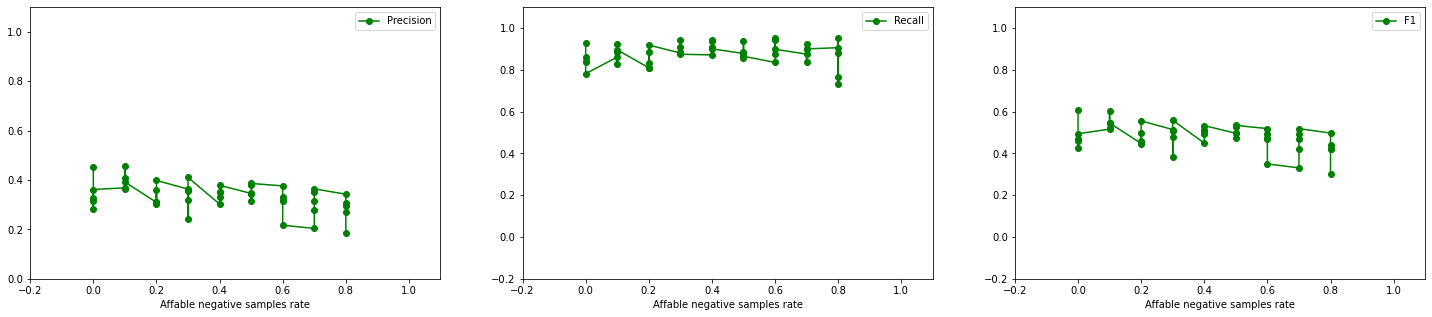

In [10]:
import warnings, matplotlib.pyplot as plt

def plot_comparison(df):
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*")

        fig, ax = plt.subplots(1,3, figsize=(25,5))
        my_colors= [ "green",  "orange"]
        
        linetype = "-"
        legend_suffix = ""


        column_renames={"Precision": "Precision" , 
                        "TrainAffableNegativeRate" : "Affable negative samples rate" ,
                        "Recall" : "Recall" , 
                        "F1": "F1" , 
                       }

        df[["Precision", "TrainAffableNegativeRate"]]\
            .rename(columns=column_renames)\
            .plot(x="Affable negative samples rate", linestyle =linetype, marker='o', ylim=(0,1.1), xlim=(-0.2, 1.1), ax=ax[0], color=(my_colors))

        df[["Recall","TrainAffableNegativeRate"]]\
            .rename(columns=column_renames)\
            .plot(x="Affable negative samples rate", linestyle =linetype, marker='o', ylim=(-0.2,1.1), xlim=(-0.2, 1.1), ax=ax[1], color=(my_colors))

        df[["F1","TrainAffableNegativeRate"]]\
            .rename(columns=column_renames)\
            .plot(x="Affable negative samples rate", linestyle =linetype, marker='o', ylim=(-0.2,1.1), xlim=(-0.2, 1.1), ax=ax[2], color=(my_colors))

       
        plt.legend()

plot_comparison(df_stats)   

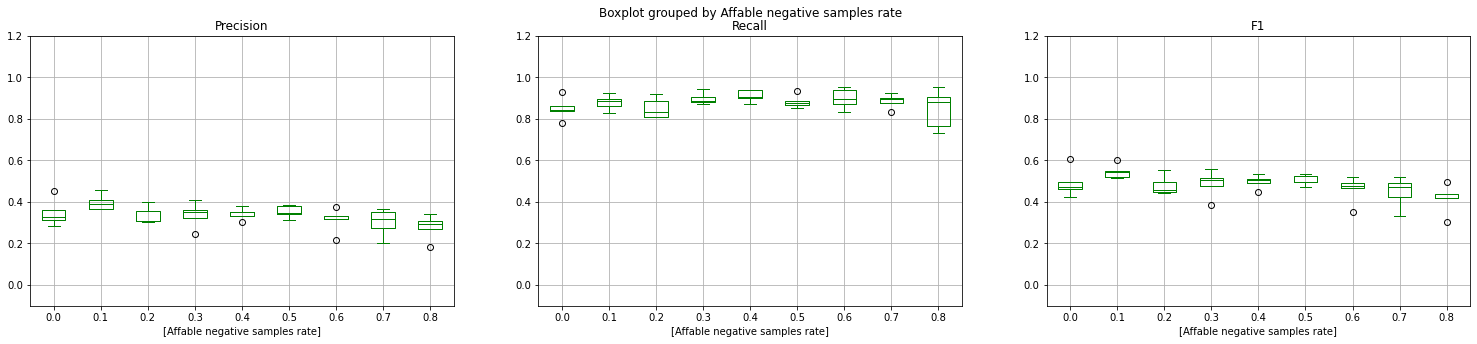

In [11]:
def plot_comparison_box(df):
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*")

        fig, ax = plt.subplots(1,3, figsize=(25,5))
        my_colors= [ "green",  "orange"]
        
        linetype = "-"
        legend_suffix = ""


        column_renames={"Precision": "Precision" , 
                        "TrainAffableNegativeRate" : "Affable negative samples rate" ,
                        "Recall" : "Recall" , 
                        "F1": "F1" , 
                       }
        ax[0].set_ylim(-0.1,1.2)
        df[["Precision", "TrainAffableNegativeRate"]]\
            .rename(columns=column_renames)\
            .boxplot(by="Affable negative samples rate",  ax=ax[0], color="green")

        ax[1].set_ylim(-0.1,1.2)
        df[["Recall","TrainAffableNegativeRate"]]\
            .rename(columns=column_renames)\
            .boxplot(by="Affable negative samples rate",  ax=ax[1], color="green")

        ax[2].set_ylim(-0.1,1.2)
        df[["F1","TrainAffableNegativeRate"]]\
            .rename(columns=column_renames)\
            .boxplot(by="Affable negative samples rate",  ax=ax[2], color="green")

       
        #plt.legend()

plot_comparison_box(df_stats)

In [12]:
df_stats

,Name,Precision,Recall,F1,Support,TrainSize,TrainSizePositive,TrainAffableNegative,TrainAffableNegativeRate,PredictionsSize,PredictionsAboveThresholdSize,PredictionsAboveThresholdRatio
0,s3://aegovan-data/selfsupervised_chemprot/pred...,0.452175,0.927812,0.608025,None,2000,500,0,0.0,500819,500819,1.0
1,s3://aegovan-data/selfsupervised_chemprot/pred...,0.283336,0.843718,0.424213,None,2000,500,0,0.0,500819,500819,1.0
2,s3://aegovan-data/selfsupervised_chemprot/pred...,0.314782,0.862405,0.461217,None,2000,500,0,0.0,500819,500819,1.0
3,s3://aegovan-data/selfsupervised_chemprot/pred...,0.326517,0.838384,0.469991,None,2000,500,0,0.0,500819,500819,1.0
4,s3://aegovan-data/selfsupervised_chemprot/pred...,0.361405,0.781039,0.494154,None,2000,500,0,0.0,500819,500819,1.0
5,s3://aegovan-data/selfsupervised_chemprot/pred...,0.368164,0.860628,0.515713,None,2000,500,150,0.1,500819,500819,1.0
6,s3://aegovan-data/selfsupervised_chemprot/pred...,0.457131,0.885062,0.602878,None,2000,500,150,0.1,500819,500819,1.0
7,s3://aegovan-data/selfsupervised_chemprot/pred...,0.409138,0.826684,0.547373,None,2000,500,150,0.1,500819,500819,1.0
8,s3://aegovan-data/selfsupervised_chemprot/pred...,0.364057,0.924794,0.522446,None,2000,500,150,0.1,500819,500819,1.0
9,s3://aegovan-data/selfsupervised_chemprot/pred...,0.391846,0.894861,0.545031,None,2000,500,150,0.1,500819,500819,1.0


In [13]:
df_stats.groupby("TrainAffableNegative").describe().T

TrainAffableNegative                           0              150   \
Precision                      count       5.000000       5.000000   
                               mean        0.347643       0.398067   
                               std         0.064765       0.037752   
                               min         0.283336       0.364057   
                               25%         0.314782       0.368164   
                               50%         0.326517       0.391846   
                               75%         0.361405       0.409138   
                               max         0.452175       0.457131   
Recall                         count       5.000000       5.000000   
                               mean        0.850672       0.878406   
                               std         0.052765       0.036940   
                               min         0.781039       0.826684   
                               25%         0.838384       0.860628   
                               50%         0.843718       0.885062   
                               75%         0.862405       0.894861   
                               max         0.927812       0.924794   
F1                             count       5.000000       5.000000   
                               mean        0.491520       0.546688   
                               std         0.069808       0.034306   
                               min         0.424213       0.515713   
                               25%         0.461217       0.522446   
                               50%         0.469991       0.545031   
                               75%         0.494154       0.547373   
                               max         0.608025       0.602878   
TrainSize                      count       5.000000       5.000000   
                               mean     2000.000000    2000.000000   
                               std         0.000000       0.000000   
                               min      2000.000000    2000.000000   
                               25%      2000.000000    2000.000000   
                               50%      2000.000000    2000.000000   
                               75%      2000.000000    2000.000000   
                               max      2000.000000    2000.000000   
TrainSizePositive              count       5.000000       5.000000   
                               mean      500.000000     500.000000   
                               std         0.000000       0.000000   
                               min       500.000000     500.000000   
                               25%       500.000000     500.000000   
                               50%       500.000000     500.000000   
                               75%       500.000000     500.000000   
                               max       500.000000     500.000000   
TrainAffableNegativeRate       count       5.000000       5.000000   
                               mean        0.000000       0.100000   
                               std         0.000000       0.000000   
                               min         0.000000       0.100000   
                               25%         0.000000       0.100000   
                               50%         0.000000       0.100000   
                               75%         0.000000       0.100000   
                               max         0.000000       0.100000   
PredictionsSize                count       5.000000       5.000000   
                               mean   500819.000000  500819.000000   
                               std         0.000000       0.000000   
                               min    500819.000000  500819.000000   
                               25%    500819.000000  500819.000000   
                               50%    500819.000000  500819.000000   
                               75%    500819.000000  500819.000000   
                               max    500819.000000  500819.000000   
Prediction

In [15]:
from scipy import stats


 
    
stats.ttest_ind(df_stats.query("TrainAffableNegativeRate == 0.0")["Precision"], 
                df_stats.query("TrainAffableNegativeRate == 0.8")["Precision"])

Ttest_indResult(statistic=1.7308138127838264, pvalue=0.12173136792451625)

In [20]:
stats.ttest_ind(df_stats.query("TrainAffableNegativeRate == 0.7")["Precision"], 
                df_stats.query("TrainAffableNegativeRate == 0.8")["Precision"])

Ttest_indResult(statistic=0.5742639308299674, pvalue=0.5815723114980638)

In [19]:
stats.ttest_ind(df_stats.query("TrainAffableNegativeRate == 0.0")["Precision"], 
                df_stats.query("TrainAffableNegativeRate == 0.7")["Precision"])

Ttest_indResult(statistic=1.1157540059939204, pvalue=0.2969179339928874)

In [16]:
stats.ttest_ind(df_stats.query("TrainAffableNegativeRate == 0.0")["Recall"], 
                df_stats.query("TrainAffableNegativeRate == 0.8")["Recall"])

Ttest_indResult(statistic=0.08210057939018815, pvalue=0.9365837108628238)

In [17]:
stats.ttest_ind(df_stats.query("TrainAffableNegativeRate == 0.0")["F1"], 
                df_stats.query("TrainAffableNegativeRate == 0.8")["F1"])

Ttest_indResult(statistic=1.7091383100188458, pvalue=0.12579995352500042)